# MBTI Personality Classification Model Based on NLP

## Backgroud & Intro
The <b>Myers-Briggs Type Indicator (MBTI)</b> was constructed by Katharine Cook Briggs and her daughter Isabel Briggs Myers. This MBTI indicator aims to make intractable theories of psychological types understandable and useful in daily lives. Participants would get a general and objective view of their personalities by filling out a questionare that takes about 30 minutes. <br><br>

The MBTI has applications in diagnosing organisational issues, teamwork (particularly quality systems), communication, counselling, careers, strategic thinking, performance appraisal, leadership and stress management.  Nowadays, the MBTI test is used as a hiring strategy for 88% of the Fortune 500 companies. It helps HR officers in large companies to determine whether your personality is suitable for the postion you applied. <br><br>

Link for MBTI test (free): https://www.16personalities.com/free-personality-test<br>
Reference: 
1. __[Detailed explanation and more info about MBTI](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/)__
2. __[Understand MBTI](https://www.personalitypathways.com/MBTI_geyer-2.html#:~:text=The%20MBTI%20has%20applications%20in,change%20situations%20in%20different%20ways.)__

## Dataset
The dataset I will be using is scraped from __[PersonalityCafe Forum](https://www.personalitycafe.com/)__ and Reddit, including a sample size of more than 8,000. For each of the individual in this dataset, their type of MBTI personality and posts are recorded for further analysis.<br><br>
Link to Dataset: https://www.kaggle.com/datasets/zeyadkhalid/mbti-personality-types-500-dataset

In [66]:
import numpy as np
import pandas as pd # data processing

In [73]:
data=pd.read_csv('mbti_2.csv')
data.head()

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


In [74]:
import matplotlib.pyplot as plt

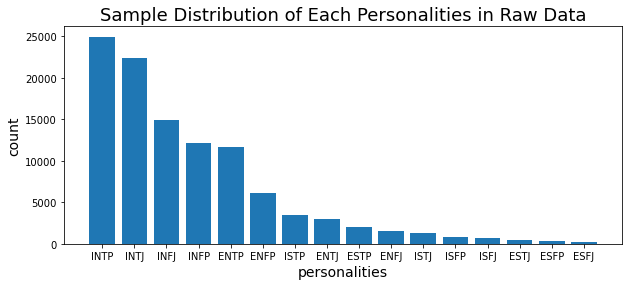

In [76]:
plt.figure(figsize=(10, 4))
plt.bar(data['type'].value_counts().index,data['type'].value_counts())
plt.title('Sample Distribution of Each Personalities in Raw Data',fontsize=18)
plt.xlabel('personalities',fontsize=14)
plt.ylabel('count',fontsize=14)
plt.show()

### Bootstraping
Since the dataset is highly unbalanced, **Bootstrapping** is used for regulating the number of samples in each class to 2000

In [77]:
from tqdm.auto import tqdm

In [78]:
def boot(group):
    temp=data[data['type']==group]
    ind=np.random.choice(temp.index,size=2000,replace=True)
    return temp.loc[ind]

boots=[]
for i in tqdm(data['type'].unique()):
    boots.append(boot(i))

data=pd.concat(boots).reset_index(drop=True)
data

,posts,type
0,say specific pair like n v meaningful fair con...,INTJ
1,really partner great entp infj romance horribl...,INTJ
2,worry sick indulge make sick feel go away say ...,INTJ
3,call president city autistic association mum p...,INTJ
4,spend lot time friend give two example give lo...,INTJ
...,...,...
31995,get confuse anyway make spain sound nice eager...,INFP
31996,know feel school still trouble get career star...,INFP
31997,pretty often hat shop clothe wear anything get...,INFP
31998,sport weather though find science around weath...,INFP


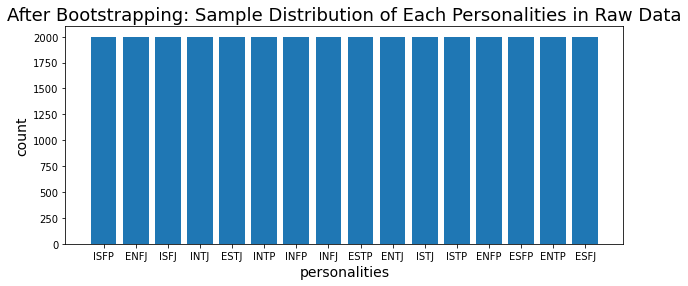

In [79]:
plt.figure(figsize=(10, 4))
plt.bar(data['type'].value_counts().index,data['type'].value_counts())
plt.title('After Bootstrapping: Sample Distribution of Each Personalities in Raw Data',fontsize=18)
plt.xlabel('personalities',fontsize=14)
plt.ylabel('count',fontsize=14)
plt.show()

## Data Processing & Tokenization

In [7]:
import re
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [8]:
def text_processing(text):
    url_pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    #lowercase
    text=text.lower()
    #remove links
    text=re.sub(url_pattern,'LINK',text)        
    #remove non-alphanumeric except for apostrophes
    text=re.sub('[^a-zA-Z\s\']',' ',text) 
    
    stops = set(stopwords.words("english"))
    return text

def tokenize(text):
    porter_stemmer  = PorterStemmer()
    words=[porter_stemmer.stem(word) for word in text.split()]
    return " ".join(words)


In [9]:
data['words']=data['posts'].apply(tokenize)
encoder=LabelEncoder()
data['label']=encoder.fit_transform(data['type'])
data.head()
%store data

Stored 'data' (DataFrame)


In [10]:
%store -r data
print(data.shape)
data.head()

(32000, 4)


,posts,type,words,label
0,win moment two people thread meet mind network...,INTJ,win moment two peopl thread meet mind network ...,10
1,honestly tell nah inxx would probably best mat...,INTJ,honestli tell nah inxx would probabl best matc...,10
2,n correctly dominant function mention fact ist...,INTJ,n correctli domin function mention fact istj g...,10
3,low testosterone additionally notice much trou...,INTJ,low testosteron addit notic much troubl spatia...,10
4,drink time shallow human vermin seem nothing i...,INTJ,drink time shallow human vermin seem noth indu...,10


## WorldClound Visualization

In [11]:
from wordcloud import WordCloud

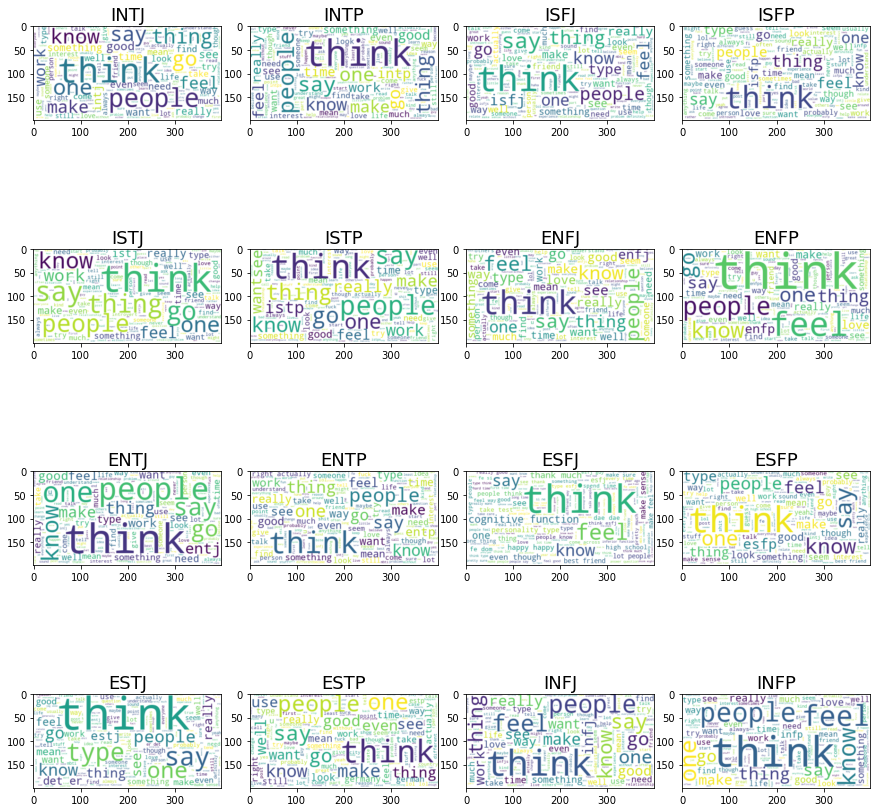

In [12]:
fig, ax = plt.subplots(16, sharex=True, figsize=(15,16))

count = 0
for i in tqdm(data['type'].unique()):
    temp = data[data['type'] == i]
    text= " ".join(list(temp['posts']))
    
    wordcloud = WordCloud(max_words=200,
                          background_color = 'White',
                          relative_scaling=1,
                          normalize_plurals=False).generate(text)
    
    plt.subplot(4,4,count+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i,fontsize=18)
    ax[count].axis("off")
    count+=1

plt.subplots_adjust(wspace=0.15, 
                    hspace=0.1)
plt.show()

## Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)#reducing the number of features for complexity
X=vectorizer.fit_transform(data['words']).todense()
y=data['label']

In [15]:
%store X
%store y

Stored 'X' (matrix)
Stored 'y' (Series)


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

xticklabels=encoder.inverse_transform([i for i in range(16)])
yticklabels=encoder.inverse_transform([i for i in range(16)])

def plot_heat(model, xticklabels, yticklabels, x, y):
    """plot heatmap of classification accuracy"""
    cm=confusion_matrix(y,
                      model.predict(x))
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(cm,
                    annot=True,
                    fmt="d",
                    cmap='Blues',
                    xticklabels=xticklabels,
                    yticklabels=yticklabels)

## Model Selection

In [17]:
from sklearn.metrics import classification_report,r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score

In [18]:
# stratified train-test split for unbanlanced data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=data.type, 
                                                    random_state=1118)
print('Train X: ',X_train.shape)
print('Test X: ', X_test.shape)
print('Train Y: ',y_train.shape)
print('Test Y: ', y_test.shape)

Train X:  (22400, 500)
Test X:  (9600, 500)
Train Y:  (22400,)
Test Y:  (9600,)


### Logistic Model (Baseline)

$$p(y|X)=\frac{ e^{w^TX}}{1+e^{w^TX}} + C||w||_2$$

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done

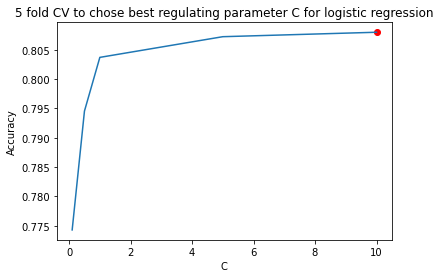

In [19]:
from sklearn.linear_model import LogisticRegression

c_logit=[0.1,0.5,1,5,10]
scores_logit=[]
for i in tqdm(c_logit):
    #weights=dict(zip(data['label'].value_counts(normalize=True)\
    #.index,data['label'].value_counts(normalize=True)))
    logit=LogisticRegression(max_iter=1000,C=i,n_jobs=-1,verbose=3)
    logit.fit(X_train, y_train)
    scores_logit.append(np.mean(cross_val_score(logit, X_train, y_train, cv=5,scoring='accuracy',n_jobs=-1,
                                               verbose=3)))
    
plt.plot(c_logit,scores_logit)
plt.title('5 fold CV to chose best regulating parameter C for logistic regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(c_logit[np.argmax(scores_logit)],scores_logit[np.argmax(scores_logit)],color='red')
plt.show()

Stored 'logit_best' (LogisticRegression)


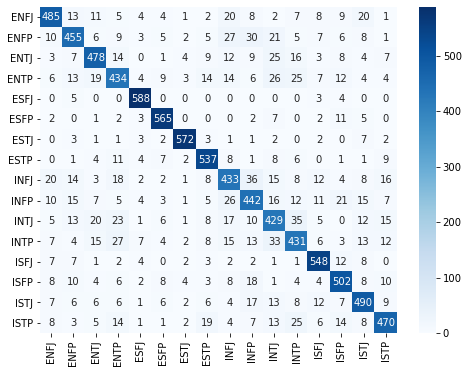

In [20]:
logit_best=LogisticRegression(max_iter=1000,C=5)
logit_best.fit(X_train, y_train)
%store logit_best
plot_heat(logit_best, xticklabels, yticklabels, X_test, y_test)

In [21]:
accuracy_score(y_test, logit_best.predict(X_test))

0.8186458333333333

The baseline Logistic Regression Model with regulating parameter C=5 gives an accuracy score of <b>0.81<b>

### Linear SVC

In [22]:
from sklearn.svm import LinearSVC

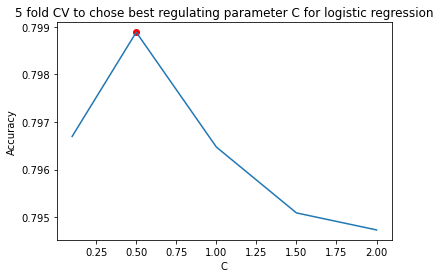

In [23]:
c_l_svc=[0.1,0.5,1,1.5,2]
scores_l_svc=[]
for i in tqdm(c_l_svc):
    linear_svc=LinearSVC(C=i)
    linear_svc.fit(X_train, y_train)
    scores_l_svc.append(np.mean(cross_val_score(linear_svc, X_train, y_train, cv=5,scoring='accuracy')))
    
plt.plot(c_l_svc,scores_l_svc)
plt.title('5 fold CV to chose best regulating parameter C for logistic regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(c_l_svc[np.argmax(scores_l_svc)],scores_l_svc[np.argmax(scores_l_svc)],color='red')
plt.show()

Stored 'linear_svm_best' (LinearSVC)


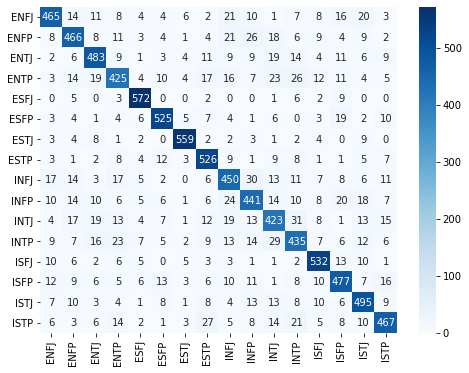

In [24]:
linear_svm_best=LinearSVC(C=0.15)
linear_svm_best.fit(X_train, y_train)
%store linear_svm_best

plot_heat(linear_svm_best, xticklabels, yticklabels, X_test, y_test)

In [25]:
accuracy_score(y_test, linear_svm_best.predict(X_test))

0.8063541666666667

The Linear SVM model with regulating parameter C=0.15 gives an accuracy score of **0.80**

### Ridge Classifer

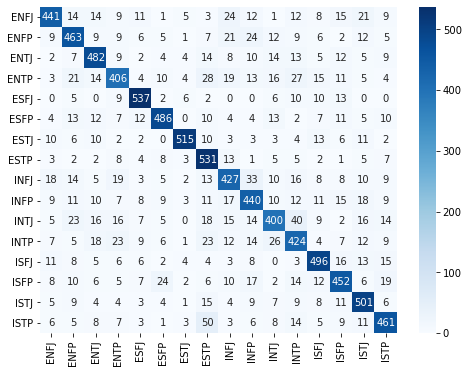

In [26]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1,5,10,100]).fit(X_train, y_train)

plot_heat(ridge, xticklabels, yticklabels, X_test, y_test)

In [27]:
accuracy_score(y_test, ridge.predict(X_test)),ridge.alpha_

(0.7772916666666667, 5.0)

The Ridge model with regulating parameter C=5 gives an accuracy score of **0.77**

### Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
n_est=[100,300,500,700,900]
scores_l_svc=[]
for i in tqdm(n_est):
    clf = RandomForestClassifier(n_estimators=i, 
                                 min_samples_split=20,
                                 random_state=0,
                                n_jobs=-1)
    clf.fit(X_train, y_train)
    scores_l_svc.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5,scoring='accuracy')))

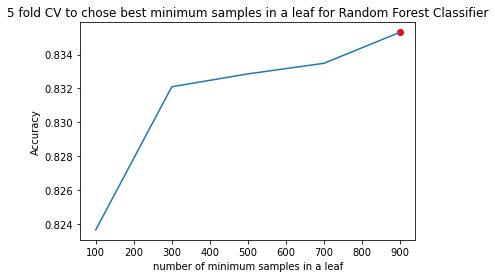

In [63]:
plt.plot(n_est,scores_l_svc)
plt.title('5 fold CV to chose best minimum samples in a leaf for Random Forest Classifier')
plt.xlabel('number of minimum samples in a leaf')
plt.ylabel('Accuracy')
plt.scatter(n_est[np.argmax(scores_l_svc)],scores_l_svc[np.argmax(scores_l_svc)],color='red')
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   34.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:    0.5s finished


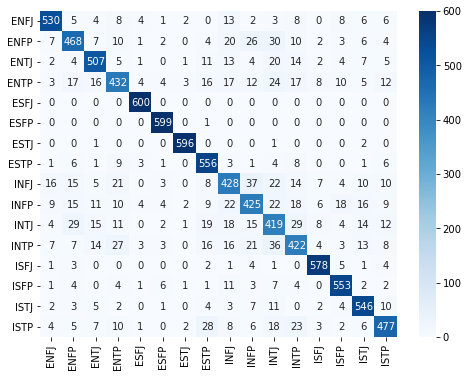

In [65]:
rf_best=RandomForestClassifier(n_estimators=900, 
                                 min_samples_split=20,
                                 random_state=0,
                                n_jobs=-1,
                                verbose=1)
rf_best.fit(X_train, y_train)

plot_heat(rf_best, xticklabels, yticklabels, X_test, y_test)

In [64]:
accuracy_score(y_test, RandomForestClassifier(n_estimators=900, 
                                 min_samples_split=20,
                                 random_state=0,
                                n_jobs=-1,
                                verbose=1).fit(X_train,y_train).predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   40.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:    0.6s finished


0.8475

The Random Forest Classifer with minimum samples in a split=20 and n_estimators=900 gives the best performance so far, with testing accuracy =**0.8475**